In [13]:
import numpy as np
from numpy import pi, arctan, sin, cos, exp
from IPython.display import Image
import pandas as pd

In [14]:
def rad_to_deg(angle):
    return angle * 180 / pi


def calculate_phi(vo, vm, alpha_i):
    return arctan((vo * sin(alpha_i)) / (vm + vo * cos(alpha_i)))


def calculate_vid(vo, vm, alpha_i):
    return (vm ** 2 + vo ** 2 + 2 * vm * vo * cos(alpha_i)) ** 0.5


def calculate_gamai(vm, vo, vt, w, alphai):
    return arctan((vm * sin(w) + vo * sin(w + alphai)) / (vm * cos(w) + vo * cos(w + alphai) - vt))


def calculate_vft(vi, vt, gammac):
    return ((vi * cos(gammac) - vt) ** 2 + (vi * sin(gammac)) ** 2) ** 0.5


def calculate_pkill(miss_distance):
    # 1.1 Material Data

    # Constants
    # Structure: mild steel
    # 1.1 Material Density
    d = 7850  # kg/m3
    # 1.2 Geometry Data
    # External diameter
    ext_diameter = 178  # mm
    # Skin thickness
    skin_thick = 2  # mm
    # Structural Diameter
    str_diameter = 154  # mm
    # Internal Diameter
    int_diameter = 144  # mm
    # Structural Thickness
    str_thick = 5  # mm
    # Effective lenght
    eff_lenght = 321  # mm

    # Structural mass (neglected endplates)
    str_mass = pi * ((str_diameter / 2 * 1e-3) ** 2 - (int_diameter / 2 * 1e-3) ** 2) * (eff_lenght * 1e-3) * d  # kg
    # 1.3 Pre-formed Fragment Data
    # Type: Sphere
    # Material: Stainless Steel
    # CONSTANTES
    # Material Density
    density = 7850  # kg/m3
    # Pattern: Brickworked
    # Diameter
    diameter = 10  # mm
    # Distance AO
    distance_ao = 10  # mm #same diameter

    # Distance AB
    distance_ab = diameter / 2  # mm
    # Distance OB
    distance_ob = (distance_ao ** 2 - distance_ab ** 2) ** 0.5  # mm
    # Sphere mass
    sphere_mass = (((diameter / 2) * 1e-3) ** (3)) * 4 * pi * density / 3  # kg
    # Number of spheres
    # In the circumference
    n = 2 * pi * (int_diameter / 2 + str_thick + diameter / 2) / diameter
    # Number of "circumference"
    n_c = eff_lenght / distance_ob
    # Total Number
    total_n = int(n * n_c)
    # Total mass of spheres
    total_mass = sphere_mass * total_n

    # 1.4 Explosive Data
    # Explosive type: PBX-9404
    # CONSTANTES
    # Explosive density:
    explo_density = 1710  # kg/m3
    # Detonation velocity
    det_velocity = 9500  # m/s
    # Gurney Constant
    gurney = 2895  # m/s
    # Initiation point (X_2)
    init_point = 100  # mm

    # Explosive mass
    explo_mass = pi * ((int_diameter / 2 * 1e-3) ** 2) * eff_lenght * 1e-3 * explo_density  # kg

    # 1.5 C/M Ratio
    cm = explo_mass / (str_mass + total_mass)

    # 2.1) Fragment Initial Velocity

    vo = 2028  # m/s
    # 2.2) Static ejection angles of fragment
    x1 = 221  # mm
    x2 = 100  # mm

    beta1rad = arctan((int_diameter / 2 + str_thick + diameter / 2) / x1)  # rad
    beta1 = beta1rad * 180 / pi  # deg
    beta2rad = arctan((int_diameter / 2 + str_thick + diameter / 2) / x2)  # rad
    beta2 = beta2rad * 180 / pi  # deg
    teta1rad = arctan(vo * cos(beta1rad) / (2 * det_velocity))  # rad
    teta1 = teta1rad * 180 / pi  # deg
    alpha1rad = pi / 2 - teta1rad  # rad
    alpha1 = alpha1rad * 180 / pi  # deg
    teta2rad = arctan(vo * cos(beta2rad) / (2 * det_velocity))  # rad
    teta2 = teta2rad * 180 / pi  # deg
    alpha2rad = pi / 2 - teta2rad  # rad
    alpha2 = alpha2rad * 180 / pi  # deg
    central_angle_alpha = (alpha1 + alpha2) / 2

    # 3.1) Missile velocity
    vm = 592  # m/s
    # 3.2) Angle between trajectories
    w = 0.0  # rad
    # 3.3) Target velocity
    vt = 250  # m/s
    # 3.4) Miss distance R
    # miss_distance = 50 #m
    # 3.5) Altitude
    altitude = 1000  # m

    # 4.1) Dynamic ejection angles of fragment referred to missile

    phi_1rad = arctan((vo * sin(alpha1rad)) / (vm + vo * cos(alpha1rad)))  # rad
    phi1 = phi_1rad * 180 / pi  # deg
    phi_2rad = arctan((vo * sin(alpha2rad)) / (vm + vo * cos(alpha2rad)))  # rad
    phi2 = phi_2rad * 180 / pi  # deg
    central_angle_phi_rad = (phi_1rad + phi_2rad) / 2
    central_angle_phi = (phi1 + phi2) / 2

    # 4.2) Dynamic initial velocity of fragment referred to missile
    vid_1 = calculate_vid(vo, vm, alpha1rad)  # m/s
    vid_2 = calculate_vid(vo, vm, alpha2rad)  # m/s
    vid_c = calculate_vid(vo, vm, central_angle_phi_rad)  # m/s

    # 4.3) Dynamic initial velocity of fragment referred to target
    # encounter angle ω
    enc_angle = 0  # rad

    gama1_rad = calculate_gamai(vm, vo, vt, w, alpha1rad)
    gama1 = rad_to_deg(gama1_rad)
    gama2_rad = calculate_gamai(vm, vo, vt, w, alpha2rad)
    gama2 = rad_to_deg(gama2_rad)
    central_angle_gama_rad = (gama1_rad + gama2_rad) / 2
    central_angle_gama = rad_to_deg(central_angle_gama_rad)
    vft = calculate_vft(vid_c, vm, central_angle_gama_rad)
    # 4.4) Distance traveled by fragments referred to target after detonation

    # Relative velocity fragment to target
    vi = 2233  # m/s
    # Time between detonation and impact
    t = miss_distance / vi  # s
    # Dist. effect. traveled by fragments
    rr = (miss_distance ** 2 / (1 - (2 * vm / vi) * cos(central_angle_gama_rad) + (vm / vft) ** 2)) ** 0.5  # m
    # 4.5) Fragment spray density
    # Target wingspan
    w = 8.13  # m
    # Length of the arc of a circumference,
    b = 2 * arctan(w / (2 * rr * sin(central_angle_gama_rad))) * rr * sin(central_angle_gama_rad)  # m
    # Area covered by spherical scattering
    ap = 2 * rr ** 2 * arctan(w / (2 * rr * sin(central_angle_gama_rad))) * (gama2_rad - gama1_rad) * sin(central_angle_gama_rad)  # m2
    # Fragment spray density
    p = total_n / (2 * pi * rr ** 2 * (cos(gama1_rad) - cos(gama2_rad)))  # frag/m2
    # Number of fragments in Zona 1
    n_frag = ap * p

    # 5) Fragment lethality
    # Drag Coefficient
    cd = 0.92
    k = 2610  # kg/m3
    # Air density
    ro = 1.225  # kg/m3
    l = 2 * (k ** 2 * sphere_mass) ** (1 / 3) / (cd * ro)
    # Impact velocity
    vx = vft * exp(-1 * rr / l)  # m/s
    # Estimated pk/h
    pkh = 0.0045

    # 6) Kill Probability
    pkd = round((1 - exp(-n_frag * pkh)) * 100, 3)
    return pkd

In [15]:
df = df = pd.read_csv('../data/df_eda_v4.csv', delimiter = ',',header=0)
df

,alt_sht,vel_sht,alt_tgt,vel_tgt,dist,pit_sht,sin(hdg_tgt),cos(hdg_tgt),sin(rgt_tgt),cos(rgt_tgt),turn_dg,delay,miss_dist
0,1900.094833,516.257515,9411.674491,389.059516,22.107204,-9.115002,-0.008574,-0.999963,0.472136,0.881526,5.107690,24.962478,12840.388130
1,1668.030968,384.114554,6424.170046,538.332386,42.957053,-9.291737,0.491448,-0.870907,0.368705,0.929546,140.635249,27.889110,68935.014560
2,1430.046650,552.946387,11292.969864,536.495037,17.904767,-16.802029,-0.946979,0.321295,0.732540,0.680724,13.967480,28.814680,15869.019903
3,1819.812543,524.681447,3983.583185,354.232941,38.858097,2.326836,-0.535011,-0.844845,-0.429737,0.902954,47.110727,25.736859,55065.305561
4,1348.600786,367.370819,8269.417066,533.015720,27.176054,13.801087,0.996601,0.082385,-0.734047,0.679098,137.619306,17.912385,47172.155816
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855050,44376.436551,544.473934,16868.508237,620.848721,32.909110,-4.773440,0.992877,0.119143,0.537314,0.843382,71.510008,21.978916,36040.502363
2855051,44396.062176,555.458863,44331.857296,626.047542,42.962424,-12.651975,0.471726,0.881745,-0.438462,0.898750,145.538436,27.934929,45979.441460
2855052,44373.716110,609.965112,16754.178594,580.015564,43.350364,-24.517640,0.196996,-0.980404,-0.284867,0.958567,79.534893,15.081863,25623.383672
2855053,44432.347726,617.846742,24860.378262,658.322238,40.760772,11.024131,-0.566162,-0.824294,0.249802,0.968297,84.072836,26.462078,9995.672595


In [16]:
df['pkill'] = df['miss_dist'].apply(calculate_pkill)
#df.drop('miss_dist', axis=1, inplace=True)
#df.to_csv('../data/df_pkill_v4.csv', index=False)

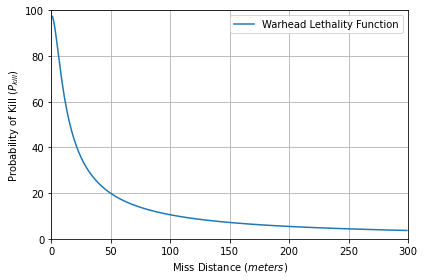

In [17]:
import matplotlib.pyplot as plt
x = []
y = []
for i in range(1,300):
    x.append(i)
    y.append(calculate_pkill(i))
    #print(f"Miss distance {i}: {calculate_pkill(i)}")
plt.figure()
plt.grid()
plt.plot(x,y)
plt.xlim(0, 300)
plt.ylim(0, 100)
plt.xlabel('Miss Distance ($meters$)')
plt.ylabel('Probability of Kill ($P_{kill}$)')
plt.legend([ 'Warhead Lethality Function'])
plt.tight_layout()
#plt.savefig('figures/pkill_eps.eps', format='eps')
#plt.savefig('figures/pkill_400dpi.png', format='png', dpi=400)

<AxesSubplot:ylabel='Frequency'>

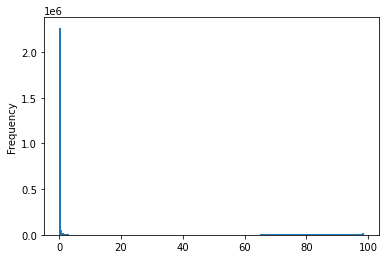

In [18]:
df['pkill'].plot.hist(bins=200)

In [19]:
df

,alt_sht,vel_sht,alt_tgt,vel_tgt,dist,pit_sht,sin(hdg_tgt),cos(hdg_tgt),sin(rgt_tgt),cos(rgt_tgt),turn_dg,delay,miss_dist,pkill
0,1900.094833,516.257515,9411.674491,389.059516,22.107204,-9.115002,-0.008574,-0.999963,0.472136,0.881526,5.107690,24.962478,12840.388130,0.087
1,1668.030968,384.114554,6424.170046,538.332386,42.957053,-9.291737,0.491448,-0.870907,0.368705,0.929546,140.635249,27.889110,68935.014560,0.016
2,1430.046650,552.946387,11292.969864,536.495037,17.904767,-16.802029,-0.946979,0.321295,0.732540,0.680724,13.967480,28.814680,15869.019903,0.070
3,1819.812543,524.681447,3983.583185,354.232941,38.858097,2.326836,-0.535011,-0.844845,-0.429737,0.902954,47.110727,25.736859,55065.305561,0.020
4,1348.600786,367.370819,8269.417066,533.015720,27.176054,13.801087,0.996601,0.082385,-0.734047,0.679098,137.619306,17.912385,47172.155816,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855050,44376.436551,544.473934,16868.508237,620.848721,32.909110,-4.773440,0.992877,0.119143,0.537314,0.843382,71.510008,21.978916,36040.502363,0.031
2855051,44396.062176,555.458863,44331.857296,626.047542,42.962424,-12.651975,0.471726,0.881745,-0.438462,0.898750,145.538436,27.934929,45979.441460,0.024
2855052,44373.716110,609.965112,16754.178594,580.015564,43.350364,-24.517640,0.196996,-0.980404,-0.284867,0.958567,79.534893,15.081863,25623.383672,0.043
2855053,44432.347726,617.846742,24860.378262,658.322238,40.760772,11.024131,-0.566162,-0.824294,0.249802,0.968297,84.072836,26.462078,9995.672595,0.111


<AxesSubplot:ylabel='Frequency'>

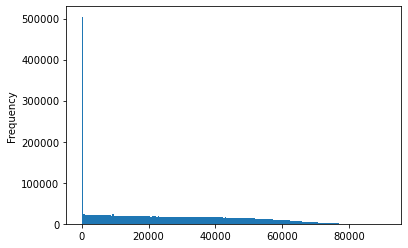

In [20]:
df['miss_dist'].plot.hist(bins=200)

In [21]:
df['kill'] = df['pkill'].apply(lambda x: True if x >= 50 else False)
df['kill'].value_counts()

False    2379708
True      475347
Name: kill, dtype: int64

In [27]:
round(df['pkill'].describe(),2)

count    2855055.00
mean          13.64
std           30.40
min            0.01
25%            0.03
50%            0.05
75%            0.23
max           98.64
Name: pkill, dtype: float64

In [31]:
df

,alt_sht,vel_sht,alt_tgt,vel_tgt,dist,pit_sht,sin(hdg_tgt),cos(hdg_tgt),sin(rgt_tgt),cos(rgt_tgt),turn_dg,delay,miss_dist,pkill,kill
0,1900.094833,516.257515,9411.674491,389.059516,22.107204,-9.115002,-0.008574,-0.999963,0.472136,0.881526,5.107690,24.962478,12840.388130,0.087,False
1,1668.030968,384.114554,6424.170046,538.332386,42.957053,-9.291737,0.491448,-0.870907,0.368705,0.929546,140.635249,27.889110,68935.014560,0.016,False
2,1430.046650,552.946387,11292.969864,536.495037,17.904767,-16.802029,-0.946979,0.321295,0.732540,0.680724,13.967480,28.814680,15869.019903,0.070,False
3,1819.812543,524.681447,3983.583185,354.232941,38.858097,2.326836,-0.535011,-0.844845,-0.429737,0.902954,47.110727,25.736859,55065.305561,0.020,False
4,1348.600786,367.370819,8269.417066,533.015720,27.176054,13.801087,0.996601,0.082385,-0.734047,0.679098,137.619306,17.912385,47172.155816,0.024,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855050,44376.436551,544.473934,16868.508237,620.848721,32.909110,-4.773440,0.992877,0.119143,0.537314,0.843382,71.510008,21.978916,36040.502363,0.031,False
2855051,44396.062176,555.458863,44331.857296,626.047542,42.962424,-12.651975,0.471726,0.881745,-0.438462,0.898750,145.538436,27.934929,45979.441460,0.024,False
2855052,44373.716110,609.965112,16754.178594,580.015564,43.350364,-24.517640,0.196996,-0.980404,-0.284867,0.958567,79.534893,15.081863,25623.383672,0.043,False
2855053,44432.347726,617.846742,24860.378262,658.322238,40.760772,11.024131,-0.566162,-0.824294,0.249802,0.968297,84.072836,26.462078,9995.672595,0.111,False


<AxesSubplot:ylabel='Frequency'>

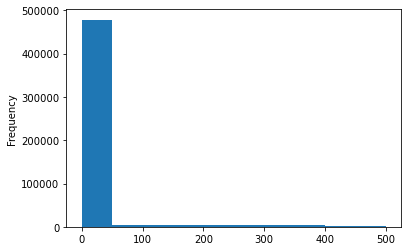

In [34]:
df_500 = df[df['miss_dist']<=500]
df_500['miss_dist'].plot.hist()

In [35]:
round(df.describe(), 2)

,alt_sht,vel_sht,alt_tgt,vel_tgt,dist,pit_sht,sin(hdg_tgt),cos(hdg_tgt),sin(rgt_tgt),cos(rgt_tgt),turn_dg,delay,miss_dist,pkill
count,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00,2855055.00
mean,21134.88,513.80,19918.72,470.47,25.00,0.00,0.00,0.00,0.00,0.83,89.98,22.50,24739.83,13.64
std,10842.30,73.84,11573.54,94.33,11.55,17.32,0.71,0.71,0.54,0.15,51.97,4.33,20805.19,30.40
min,1000.00,300.00,1000.01,300.00,5.00,-30.00,-1.00,-1.00,-0.87,0.50,0.00,15.00,0.00,0.01
25%,12367.06,462.20,10282.47,393.10,15.01,-15.00,-0.71,-0.71,-0.50,0.71,44.96,18.75,4881.81,0.03
50%,21503.77,523.89,18973.59,469.85,24.99,-0.01,0.00,0.00,0.00,0.87,90.01,22.50,21780.30,0.05
75%,29201.76,572.36,28622.25,544.19,35.01,15.01,0.71,0.71,0.50,0.97,134.97,26.26,41171.43,0.23
max,44999.87,653.48,44999.95,700.00,45.00,30.00,1.00,1.00,0.87,1.00,180.00,30.00,91069.93,98.64


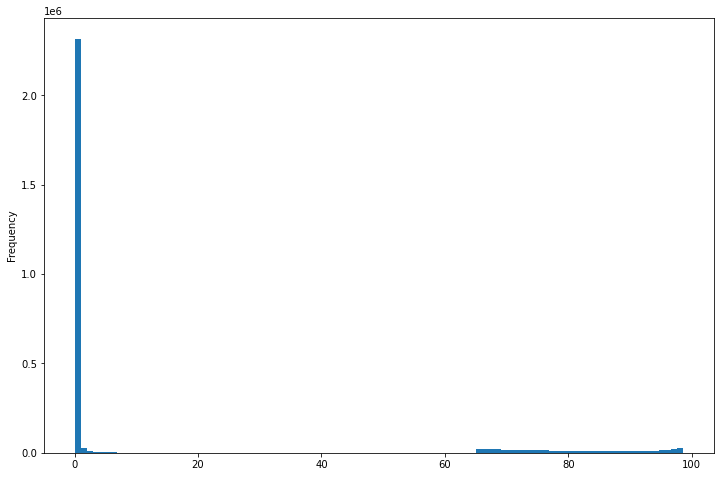

In [36]:
df['pkill'].plot.hist(figsize=(12,8), bins=100);

In [37]:
round(df['pkill'].describe(),2)

count    2855055.00
mean          13.64
std           30.40
min            0.01
25%            0.03
50%            0.05
75%            0.23
max           98.64
Name: pkill, dtype: float64

In [38]:
df2 = df[df['pkill']>=0.05]

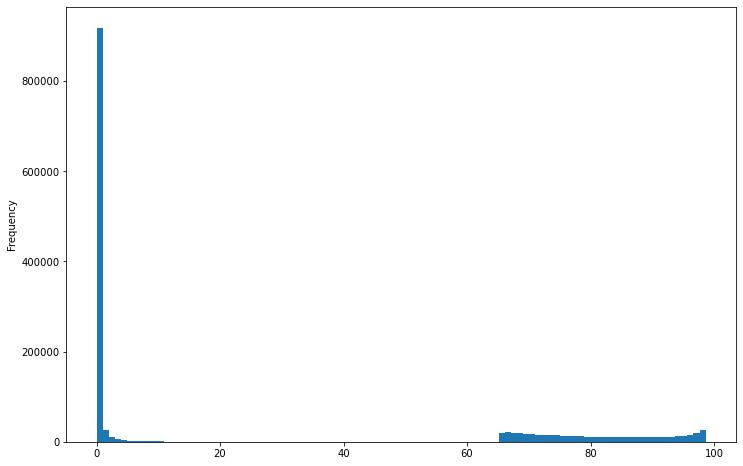

In [39]:
df2['pkill'].plot.hist(figsize=(12,8), bins=100);

In [40]:
calculate_pkill(20805.19)

0.053

In [41]:
round(df2['pkill'].describe(),2)

count    1453719.00
mean          26.76
std           38.26
min            0.05
25%            0.08
50%            0.22
75%           70.67
max           98.64
Name: pkill, dtype: float64